In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm



In [3]:
data = pd.read_csv('network_ids_data .csv')
data.head()

,Flow Duration,Total Fwd Packets,Fwd Packet Length Mean,Bwd Packet Length Mean,Flow IAT Mean,SYN Flag Count,FIN Flag Count,Active Mean,Idle Mean,Label
0,32046067,2,37.000000,0.000000,3.200000e+07,1,0,0.0,0.0,BENIGN
1,66073,4,44.000000,107.000000,9.439000e+03,0,0,0.0,0.0,BENIGN
2,60025,1,56.000000,112.000000,6.002500e+04,0,0,0.0,0.0,BENIGN
3,47619,1,44.000000,213.000000,4.761900e+04,0,0,0.0,0.0,BENIGN
4,99329635,6,53.333333,1656.428571,8.277470e+06,0,1,13973.0,99300000.0,DoS Hulk


In [4]:
data.shape

(1500000, 10)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Flow Duration           1500000 non-null  int64  
 1   Total Fwd Packets       1500000 non-null  int64  
 2   Fwd Packet Length Mean  1500000 non-null  float64
 3   Bwd Packet Length Mean  1500000 non-null  float64
 4   Flow IAT Mean           1500000 non-null  float64
 5   SYN Flag Count          1500000 non-null  int64  
 6   FIN Flag Count          1500000 non-null  int64  
 7   Active Mean             1500000 non-null  float64
 8   Idle Mean               1500000 non-null  float64
 9   Label                   1500000 non-null  object 
dtypes: float64(5), int64(4), object(1)
memory usage: 114.4+ MB


<Axes: >

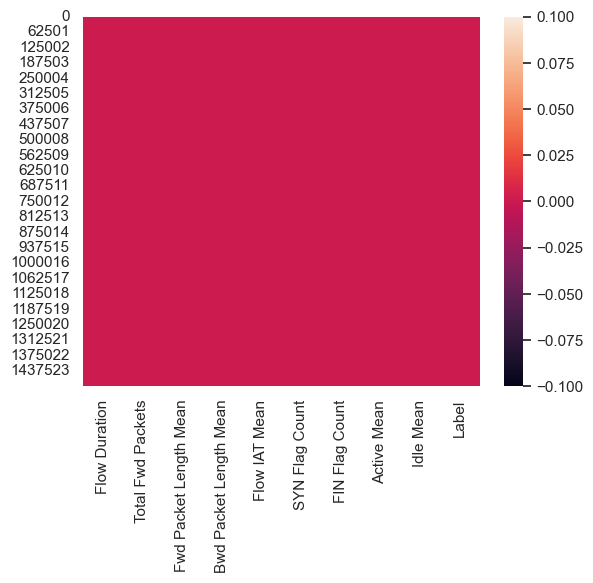

In [6]:
sns.heatmap(data.isnull())

In [7]:
data.duplicated().sum()

np.int64(510412)

In [8]:
data.drop_duplicates(inplace = True)
data.shape

(989588, 10)

In [9]:
numeric_cols = data.select_dtypes(include = np.number).columns#if we have infinity values in the data
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Series([], dtype: int64)


In [10]:
target = "Label"
class_distribution = Counter(data[target])

print("Class distribution before handling imbalance:")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} samples")


Class distribution before handling imbalance:
Class BENIGN: 814922 samples
Class DoS Hulk: 89086 samples
Class FTP-Patator: 2297 samples
Class PortScan: 1088 samples
Class DDoS: 67693 samples
Class DoS Slowhttptest: 2765 samples
Class DoS slowloris: 2691 samples
Class Web Attack � XSS: 353 samples
Class Bot: 742 samples
Class DoS GoldenEye: 5465 samples
Class SSH-Patator: 1686 samples
Class Web Attack � Brute Force: 766 samples
Class Infiltration: 19 samples
Class Web Attack � Sql Injection: 11 samples
Class Heartbleed: 4 samples


In [11]:


scaler = MinMaxScaler()

# Identify numeric columns
num_columns = data.select_dtypes(include=np.number).columns

# Apply MinMaxScaler
data[num_columns] = scaler.fit_transform(data[num_columns])

In [12]:
data

,Flow Duration,Total Fwd Packets,Fwd Packet Length Mean,Bwd Packet Length Mean,Flow IAT Mean,SYN Flag Count,FIN Flag Count,Active Mean,Idle Mean,Label
0,0.267051,0.000005,0.006230,0.000000,0.266667,1.0,0.0,0.000000,0.0000,BENIGN
1,0.000551,0.000014,0.007408,0.018447,0.000079,0.0,0.0,0.000000,0.0000,BENIGN
2,0.000500,0.000000,0.009429,0.019309,0.000500,0.0,0.0,0.000000,0.0000,BENIGN
3,0.000397,0.000000,0.007408,0.036721,0.000397,0.0,0.0,0.000000,0.0000,BENIGN
4,0.827747,0.000023,0.008980,0.285567,0.068979,0.0,1.0,0.000127,0.8275,DoS Hulk
...,...,...,...,...,...,...,...,...,...,...
1499991,0.000199,0.000005,0.006566,0.009482,0.000067,0.0,0.0,0.000000,0.0000,BENIGN
1499993,0.003346,0.000009,0.031990,0.000690,0.000669,0.0,0.0,0.000000,0.0000,BENIGN
1499994,0.006264,0.000037,0.013152,0.061907,0.000330,0.0,0.0,0.000000,0.0000,BENIGN
1499998,0.000259,0.000000,0.008924,0.024308,0.000259,0.0,0.0,0.000000,0.0000,BENIGN


In [13]:
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])


In [14]:
data

,Flow Duration,Total Fwd Packets,Fwd Packet Length Mean,Bwd Packet Length Mean,Flow IAT Mean,SYN Flag Count,FIN Flag Count,Active Mean,Idle Mean,Label
0,0.267051,0.000005,0.006230,0.000000,0.266667,1.0,0.0,0.000000,0.0000,0
1,0.000551,0.000014,0.007408,0.018447,0.000079,0.0,0.0,0.000000,0.0000,0
2,0.000500,0.000000,0.009429,0.019309,0.000500,0.0,0.0,0.000000,0.0000,0
3,0.000397,0.000000,0.007408,0.036721,0.000397,0.0,0.0,0.000000,0.0000,0
4,0.827747,0.000023,0.008980,0.285567,0.068979,0.0,1.0,0.000127,0.8275,4
...,...,...,...,...,...,...,...,...,...,...
1499991,0.000199,0.000005,0.006566,0.009482,0.000067,0.0,0.0,0.000000,0.0000,0
1499993,0.003346,0.000009,0.031990,0.000690,0.000669,0.0,0.0,0.000000,0.0000,0
1499994,0.006264,0.000037,0.013152,0.061907,0.000330,0.0,0.0,0.000000,0.0000,0
1499998,0.000259,0.000000,0.008924,0.024308,0.000259,0.0,0.0,0.000000,0.0000,0


In [17]:

# Assume `data` is a DataFrame with preprocessed features and target column

# Split data into features (X) and labels (y)
X = data.iloc[:, :-1].values  # All columns except 'Label'
y = data['Label'].values  # The 'Label' column

# Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)  # Use long for classification
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [19]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add a dummy time dimension
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out

# Instantiate the model
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(np.unique(y))  # Number of unique labels
model = LSTMModel(input_size, hidden_size, num_classes).to(device)



In [20]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




In [21]:
# Training parameters
num_epochs = 10
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

# Training Loop
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break



Training Epochs:  10%|█         | 1/10 [01:05<09:52, 65.80s/it]

Epoch 1/10, Train Loss: 0.2617, Val Loss: 0.1575, Val Accuracy: 0.9597


Training Epochs:  20%|██        | 2/10 [01:54<07:24, 55.61s/it]

Epoch 2/10, Train Loss: 0.1368, Val Loss: 0.1089, Val Accuracy: 0.9653


Training Epochs:  30%|███       | 3/10 [03:00<07:03, 60.51s/it]

Epoch 3/10, Train Loss: 0.0988, Val Loss: 0.0832, Val Accuracy: 0.9784


Training Epochs:  40%|████      | 4/10 [04:17<06:41, 66.84s/it]

Epoch 4/10, Train Loss: 0.0799, Val Loss: 0.0699, Val Accuracy: 0.9813


Training Epochs:  50%|█████     | 5/10 [05:03<04:57, 59.45s/it]

Epoch 5/10, Train Loss: 0.0705, Val Loss: 0.0666, Val Accuracy: 0.9826


Training Epochs:  60%|██████    | 6/10 [05:59<03:53, 58.31s/it]

Epoch 6/10, Train Loss: 0.0639, Val Loss: 0.0616, Val Accuracy: 0.9828


Training Epochs:  70%|███████   | 7/10 [07:41<03:38, 72.71s/it]

Epoch 7/10, Train Loss: 0.0592, Val Loss: 0.0551, Val Accuracy: 0.9839


Training Epochs:  80%|████████  | 8/10 [09:42<02:55, 87.90s/it]

Epoch 8/10, Train Loss: 0.0555, Val Loss: 0.0523, Val Accuracy: 0.9846


Training Epochs:  90%|█████████ | 9/10 [11:33<01:35, 95.11s/it]

Epoch 9/10, Train Loss: 0.0528, Val Loss: 0.0491, Val Accuracy: 0.9849


Training Epochs: 100%|██████████| 10/10 [13:16<00:00, 79.62s/it]

Epoch 10/10, Train Loss: 0.0507, Val Loss: 0.0467, Val Accuracy: 0.9857


In [22]:
# Test phase
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        test_labels.extend(y_batch.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(test_labels, test_preds))

Test Accuracy: 0.9854
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    122274
           1       0.00      0.00      0.00       129
           2       0.98      0.98      0.98     10165
           3       0.97      0.93      0.95       798
           4       1.00      0.92      0.96     13341
           5       0.87      0.89      0.88       400
           6       0.93      0.89      0.91       417
           7       1.00      0.92      0.95       331
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00       168
          11       0.99      0.88      0.93       241
          12       0.00      0.00      0.00       120
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        52

    accuracy                           0.99    148439
   macro avg       0.55      0.53      0.54    148439
weighted avg       0.98      0.99      0.98    148439



c:\Users\Ahmed fawzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ahmed fawzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ahmed fawzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa